In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import functorch
import matplotlib.pyplot as plt

import os
from datetime import datetime
import time

import Double_Pendulum.Lumped_Mass.robot_parameters as robot_parameters
import Double_Pendulum.Lumped_Mass.transforms as transforms
import Double_Pendulum.Lumped_Mass.dynamics as dynamics
import Learning.loss_terms as loss_terms
import Plotting.plotters_h1h2 as plotters_h1h2
import Learning.training_data as training_data


/home/kian/anaconda3/envs/thesis/lib/python3.12/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rp = robot_parameters.LUMPED_PARAMETERS
print(rp)

{'l1': 2, 'l2': 2, 'm': 3, 'g': 9.81, 'xa': 5, 'ya': 1}


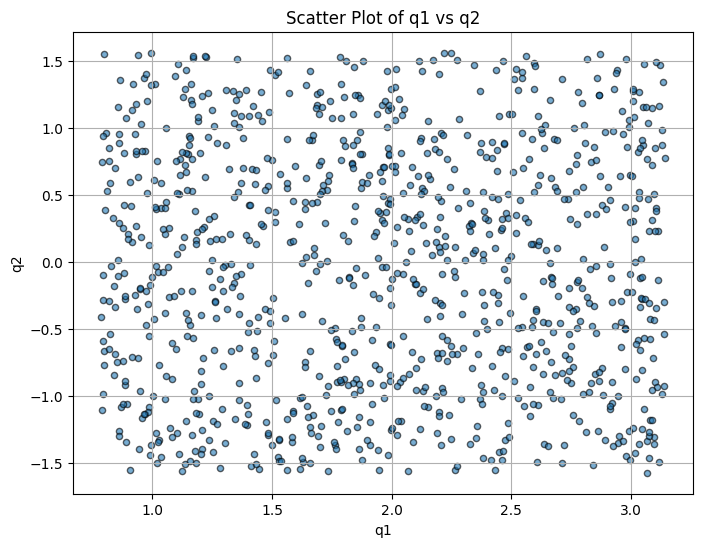

In [3]:
import numpy as np


# Retrieve training points
points = training_data.points.to(device) 


# Plot q1 vs q2
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0].numpy(), points[:, 1].numpy(), alpha=0.6, edgecolors='k', s=20)
plt.title('Scatter Plot of q1 vs q2')
plt.xlabel('q1')
plt.ylabel('q2')
plt.grid(True)
plt.show()

In [4]:
# Split into training and test sets (80% train, 20% test)
train_part = 0.8
train_size = int(train_part * len(points))
test_size = len(points) - train_size

train_points, test_points = torch.split(points, [train_size, test_size])

# Create TensorDataset for both training and testing sets
train_dataset = TensorDataset(train_points)
test_dataset = TensorDataset(test_points)

# Create the DataLoader for both training and testing sets
batch_size = 64
train_dataloader = DataLoader(train_dataset, 
                               batch_size=batch_size, 
                               shuffle=True,
                               num_workers=0,
                               pin_memory=True)

test_dataloader = DataLoader(test_dataset, 
                              batch_size=batch_size, 
                              shuffle=False,
                              num_workers=0,
                              pin_memory=True)


# Example usage: iterate through the DataLoader
for batch in train_dataloader:
    #print(batch[0])
    break  # Just to show one batch

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, rp):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 6),
            nn.Sigmoid(),
            nn.Linear(6, 6),
            nn.Sigmoid(),
            nn.Linear(6, 2)
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 6),
            nn.Sigmoid(),
            nn.Linear(6, 6),
            nn.Sigmoid(),
            nn.Linear(6, 2)
        )
        
        self.rp = rp
        
    def encoder_theta_1_ana(self, q):
        theta_1 = transforms.analytic_theta_1(self.rp, q).unsqueeze(0)
        return theta_1, theta_1
    
    #This function is not used in the forward pass, but is useful for comparing learned to analytic theta_2
    def encoder_theta_2_ana(self, q):
        theta_2 = transforms.analytic_theta_2(self.rp, q).unsqueeze(0)
        return theta_2, theta_2

    def encoder_nn(self, q):
        theta = self.encoder(q)
        return theta, theta
    
    def forward(self, q):
        
        J_h_1_ana, theta_1_ana = torch.vmap(torch.func.jacfwd(self.encoder_theta_1_ana, has_aux=True))(q)
        
        J_h, theta = torch.vmap(torch.func.jacfwd(self.encoder_nn, has_aux=True))(q)


        J_h_2_ana, theta_2_ana = torch.vmap(torch.func.jacfwd(self.encoder_theta_2_ana, has_aux=True))(q)
        
        J_h_ana = torch.cat((J_h_1_ana, J_h_2_ana), dim=1)

        q_hat = self.decoder(theta)
        return(theta, J_h, q_hat, J_h_ana)

In [6]:
%%time
%matplotlib widget

current_time = datetime.now().strftime("%Y%m%d%H%M")
save_directory = os.path.join(os.getcwd(), "Models")
os.makedirs(save_directory, exist_ok=True)
file_name = f"Lumped_Mass_{current_time}.pth"
file_path = os.path.join(save_directory, file_name)

load_path = os.path.normpath("/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411271337.pth")


rp = robot_parameters.LUMPED_PARAMETERS
num_epochs = 4801

print(file_path)
model = Autoencoder(rp).to(device)  # Move model to GPU
#model.load_state_dict(torch.load(load_path, weights_only=True))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2, alpha=0.99, eps=1e-08)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1 ** (1 / num_epochs))



l_weights = [1,
             1,
             1e-1,
             1e-2]
outputs = []



plt.ion()

for epoch in range(num_epochs):
    for index, batch in enumerate(train_dataloader):
        batch_size = batch[0].shape[0]
        q = batch[0][:, 0:2].to(device)
        q.requires_grad = True
        q_d = batch[0][:, 2:4].to(device)
        
        theta, J_h, q_hat, J_h_ana = model(q)  
                
        matrices_vmap = torch.vmap(dynamics.dynamical_matrices, 
                                   in_dims=(None, 0, 0))


        M_q, C_q, G_q = matrices_vmap(rp, q, q_d)

        input_matrix_vmap = torch.vmap(dynamics.input_matrix, in_dims=(None, 0))
        A_q = input_matrix_vmap(rp, q)
        
        M_th, C_th, G_th = transforms.transform_dynamical_matrices(M_q, C_q, G_q, J_h, device)  
        A_th = transforms.transform_input_matrix(A_q, J_h, device)

            
        
        #loss_reconstruction = loss_terms.loss_reconstruction(q, q_hat)
        loss_diagonality_geo_mean = loss_terms.loss_diagonality_geo_mean(M_th, batch_size, device)
        #loss_diagonality_trace = loss_terms.loss_diagonality_trace(M_th, batch_size, device)
        #loss_diagonality_smallest = loss_terms.loss_diagonality_smallest(M_th, batch_size, device)
        ### Use J@J^T = eye to avoid needing to calculate the Jacobian inverse for efficiency. 
        loss_J_h_unitary = loss_terms.loss_J_h_unitary(J_h, batch_size, device)
        loss_J_h_cheat = loss_terms.loss_J_h_cheat(J_h, J_h_ana)
        loss_input_decoupling = loss_terms.loss_input_decoupling(A_th, batch_size, device)
        loss_h1_shaping = loss_terms.loss_h1_shaping(J_h, A_q, device)
        #loss_M_th_cheat = loss_terms.loss_M_th_cheat(M_th, rp, q, q_d, batch_size)
        #l1_norm = loss_terms.loss_l1(model)
        
        #loss_diagonality = 10 * loss_diagonality_geo_mean + loss_diagonality_smallest + 100 * loss_diagonality_trace
        loss_diagonality = loss_diagonality_geo_mean


        loss = 0.1 * loss_diagonality + 10 * loss_J_h_unitary + 5 *loss_input_decoupling #+ loss_h1_shaping

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()




    if torch.sum(torch.isnan(J_h)) > 0:
        print("UHOHHHH")
        break


    if epoch % 200 == 0:
        print(f'Epoch:{epoch+1}, Loss:{loss.item():.9f}')#, LR:{scheduler.get_last_lr():.7f}')
        print("Weighted loss_diagonality_geo_mean:", 0.1 * loss_diagonality_geo_mean.item())
        #print("Weighted loss_diagonality_smallest:", loss_diagonality_smallest)
        #print("Weighted loss_diagonality_trace:", 100 * loss_diagonality_trace)
        print("Weighted loss Jh unitary:", 10 * loss_J_h_unitary.item())
        print("Weighted loss input decoupling:", 5 * loss_input_decoupling.item())
        #print("Weighted loss h1 shaping:", loss_h1_shaping.item())
        J_h_trans = J_h.transpose(-2,-1)
        dot_product = torch.bmm(J_h_trans, J_h)
        print("J_h_unitary:", dot_product[0])
        print("A_th:", A_th[0])
    if epoch % 1600 == 0 and epoch > 0:
        plotters_h1h2.plot_h(model, device, rp, epoch, h = 0)
        plotters_h1h2.plot_h(model, device, rp, epoch, h = 1)
        #plotters_h1h2.plot_J_h(model, device, rp, epoch, plot_index = 0)
        #plotters_h1h2.plot_J_h(model, device, rp, epoch, plot_index = 1)
        plotters_h1h2.plot_decoupling(model, device, rp, epoch)
    scheduler.step()

    outputs.append((epoch, loss, q, q_hat, theta, M_th))


torch.save(model.state_dict(), file_path)
print(f"Model parameters saved to {file_path}")

/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202412031755.pth
Epoch:1, Loss:7.286662579
Weighted loss_diagonality_geo_mean: 0.018156322836875915
Weighted loss Jh unitary: 4.9926358461380005
Weighted loss input decoupling: 2.27587029337883
J_h_unitary: tensor([[0.0006, 0.0004],
        [0.0004, 0.0003]], grad_fn=<SelectBackward0>)
A_th: tensor([[0.0518],
        [0.0563]], grad_fn=<SelectBackward0>)
Epoch:201, Loss:1.523274660
Weighted loss_diagonality_geo_mean: 0.032669353485107425
Weighted loss Jh unitary: 1.1179782450199127
Weighted loss input decoupling: 0.3726271912455559
J_h_unitary: tensor([[ 0.8133, -0.1660],
        [-0.1660,  0.7376]], grad_fn=<SelectBackward0>)
A_th: tensor([[1.2853],
        [0.2418]], grad_fn=<SelectBackward0>)
Epoch:401, Loss:1.543552160
Weighted loss_diagonality_geo_mean: 0.03594760298728943
Weighted loss Jh unitary: 1.0486699640750885
Weighted loss input decoupling: 0.45893460512161255
J_h_unitary: tensor([[1.0822, 0.0622],

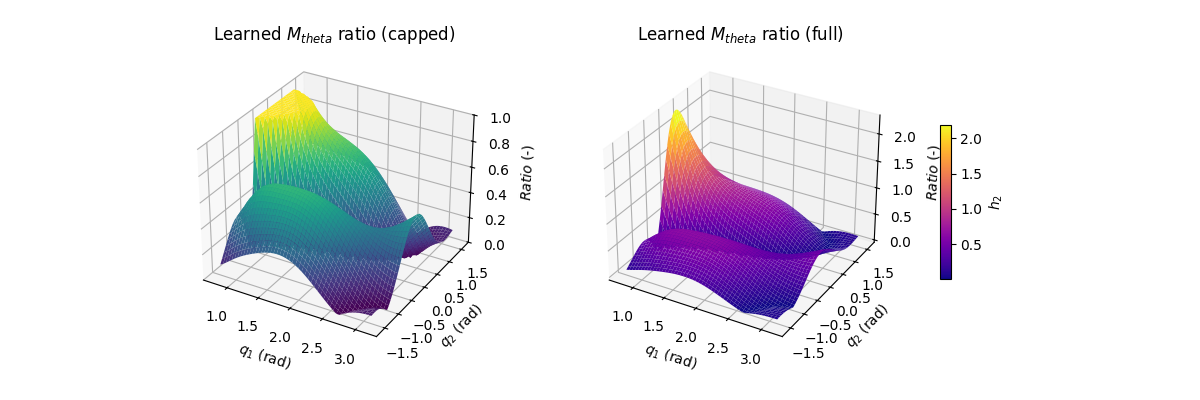

In [ ]:
epoch = 1
plotters_h1h2.plot_decoupling(model, device, rp, epoch)

In [ ]:
q_test = torch.tensor([[2.4, 2.]]).to(device)
theta, J_h, q_hat, J_h_ana = model(q_test)


J_h_inv = J_h.transpose(1,2).to(device)
J_h_inv_trans = J_h.to(device)



print("J_h:\n", J_h.detach().cpu().numpy()[0])
print("J_h_inv:\n", J_h_inv.detach().cpu().numpy()[0])


J_h_inv_true = torch.linalg.pinv(J_h).to(device)
J_h_inv_trans_true = J_h_inv.transpose(1,2).to(device)
print("J_h_inv_true:\n", J_h_inv_true.detach().cpu().numpy()[0])
print("J_h_inv_trans_true:\n", J_h_inv_trans_true.detach().cpu().numpy()[0])

M_q, C_q, G_q = dynamics.dynamical_matrices(rp, q_test[0], q_test[0])
M_q = M_q.unsqueeze(0)
M_th, C_th, G_th = transforms.transform_dynamical_matrices(M_q, C_q, G_q, J_h, device)
print("M_q:", M_q)
print("M_th:\n", M_th)


off_dia = M_th[:, 1,0]
diag_elements = M_th[:, [0, 1], [0, 1]]
diag_product = torch.sqrt(diag_elements[:, 0] * diag_elements[:, 1] + 1e-6)
M_th_ratio = off_dia/diag_product
print("M_th_ratio:", M_th_ratio)

print("M_q:\n", M_q)

print("J_h_ana:\n", J_h_ana.detach().cpu().numpy()[0], "\n")
J_h_ana_inv = torch.linalg.pinv(J_h_ana)
J_h_ana_inv_trans = J_h_ana_inv.transpose(1,2)

print("J_h_ana_inv:\n", J_h_ana_inv.detach().cpu().numpy()[0], "\n")


M_th_ana, C_th_ana, G_th_ana = dynamics.dynamical_matrices_th(rp, q_test[0], q_test[0]) 
print("M_th_ana:", M_th_ana.detach().cpu().numpy())

J_h:
 [[ 0.6904618   0.40520468]
 [ 0.20891531 -0.20097724]]
J_h_inv:
 [[ 0.6904618   0.20891531]
 [ 0.40520468 -0.20097724]]
J_h_inv_true:
 [[ 0.89954704  1.8136408 ]
 [ 0.9350767  -3.090413  ]]
J_h_inv_trans_true:
 [[ 0.6904618   0.40520468]
 [ 0.20891531 -0.20097724]]
M_q: tensor([[[12.0000, 11.0527],
         [11.0527, 12.0000]]])
M_th:
 tensor([[[13.8758,  0.1556],
         [ 0.1556,  0.0803]]], grad_fn=<UnsafeViewBackward0>)
M_th_ratio: tensor([0.1474], grad_fn=<DivBackward0>)
M_q:
 tensor([[[12.0000, 11.0527],
         [11.0527, 12.0000]]])
J_h_ana:
 [[0.8752869  1.5064826 ]
 [0.23592417 0.172583  ]] 

J_h_ana_inv:
 [[-0.8445209  7.3718524]
 [ 1.1544762 -4.2831473]] 

M_th_ana: [[  3.        0.     ]
 [  0.      174.30078]]


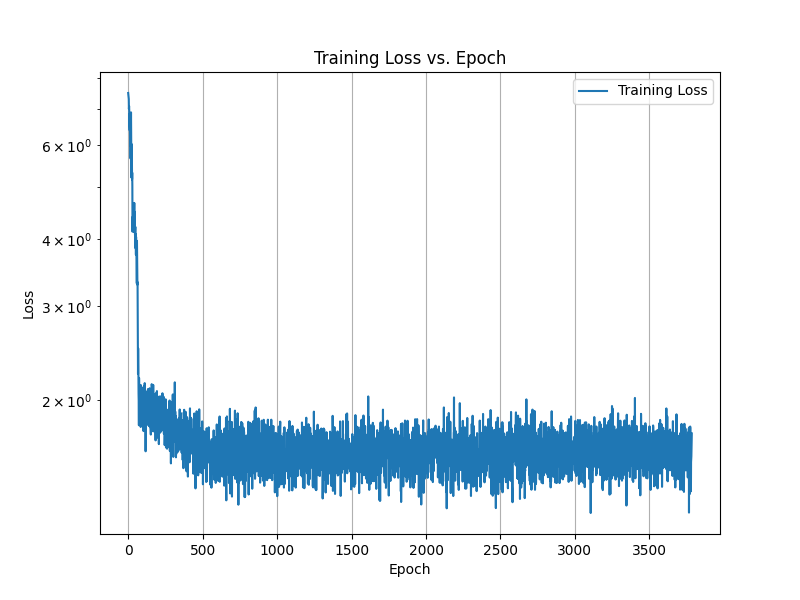

In [ ]:
# Extract epochs and losses
epochs = [entry[0] for entry in outputs]
losses = [entry[1].item() for entry in outputs]

# Plot loss as a function of epoch
plt.figure(figsize=(8, 6))
plt.plot(epochs, losses, marker='', label='Training Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()


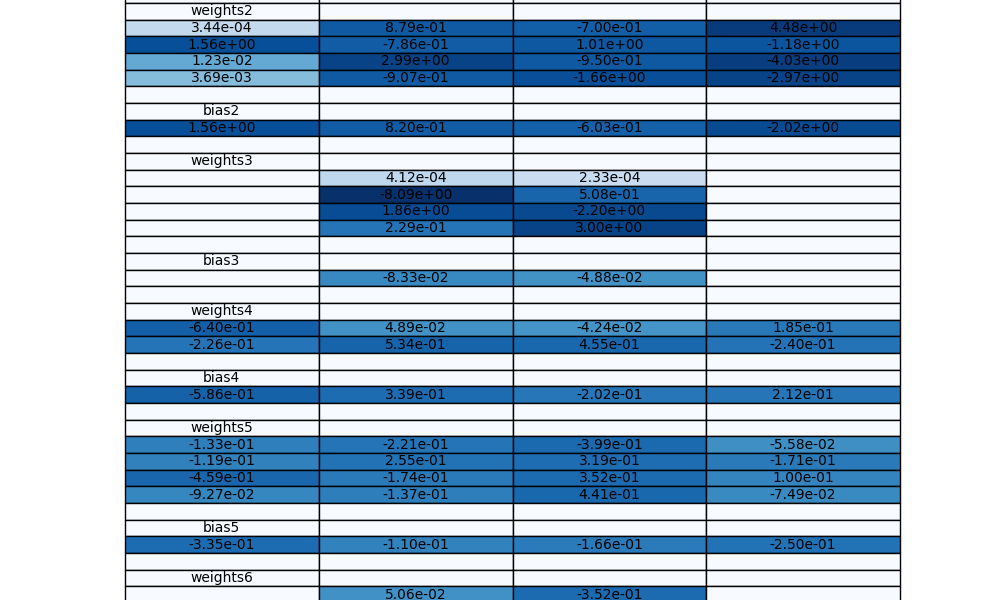

In [ ]:
import random
import string

max_neurons = 4
blank_layer = [None for _ in range(max_neurons)]

table_layers = []
for idx, param in enumerate(model.parameters()):
    layer = param.data
    num_parallel = layer.shape[0]
    side_padding = int((max_neurons - num_parallel)/2)
    
    if idx % 2 == 0:
        
        table_layer = blank_layer.copy()
        table_layer[0] = "weights" + str(idx//2+1)
        table_layers.append(table_layer)
        for i in range(layer.shape[1]):
            table_layer = blank_layer.copy()
            for j in range(num_parallel):
                table_layer[j+side_padding] = '{:.2e}'.format(layer[j][i].item())
            table_layers.append(table_layer)
        table_layers.append(blank_layer)
            
    else:  
        
        table_layer = blank_layer.copy()
        table_layer[0] = "bias" + str(idx//2+1)
        table_layers.append(table_layer)
        table_layer = blank_layer.copy()
        for j in range(num_parallel):
            table_layer[j+side_padding] = '{:.2e}'.format(layer[j].item())
        table_layers.append(table_layer)
        table_layers.append(blank_layer)

numeric_values = np.zeros((len(table_layers), max_neurons))
for i, row in enumerate(table_layers):
    for j, item in enumerate(row):
        if item not in (None, "weights1", "weights2", "bias1", "bias2"):  # Replace with relevant layer names
            try:
                numeric_values[i, j] = (float(item))
            except ValueError:
                pass
        
min_val, max_val = numeric_values.min(), numeric_values.max()


# Step 2: Apply a logarithmic transformation, setting a small threshold to avoid log(0)
threshold = 1e-5
log_values = np.log10(np.clip(np.abs(numeric_values), threshold, None))

# Normalize the log-scaled values to range between 0 and 1
normalized_values = (log_values - log_values.min()) / (log_values.max() - log_values.min())
colors = plt.cm.Blues(normalized_values)

        
# Plot the table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

# Create table
table = plt.table(cellText=table_layers, cellColours=colors, loc='center', cellLoc='center')

plt.show()